# Pseudomonas in water tutorial

*Pseudomonas aeruginosa* is a ubiquitous environmental bacterium and opportunistic pathogen that can infect vulnerable patients, for example on the intensive care unit. *P. aeruginosa* is also commonly drug resistant, and in some cases can become extensively drug resistant, making it hard to treat. In a hospital in the UK we tracked an outbreak of *P. aeruginosa* and determined that patients were becoming infected from water outlets near where they were being nursed. 

This task asks you to become a disease detective and, using the knowledge of alignments, variant calling and assembly you have acquired during this course, work out which water outlet a patient infection is associated with. The patient was treated with numerous antibiotics during their stay - from the genome sequence can you figure out what antibiotics the organism is likely to be resistant to?


## References

Quick et al. Seeking the source of Pseudomonas aeruginosa infections in a recently opened hospital: an observational study using whole-genome sequencing. http://bmjopen.bmj.com/content/4/11/e006278.f…

## Data
We have provided 5 sets of reads, each from the Illumina MiSeq sequencer.:

Download them from:
http://www.microbesng.uk/filedist/pseudomonas-practical/

## Task

  * Quality assess your reads: how long are they? How long are the inserts?
  * Align your reads to the supplied Pseudomonas reference sequence (ST17.fasta, the annotations are further in ST17.gff):
     * What proportion of reads map for each sample?
     * What is the approximate coverage of your genome?
     * How many differences are there between the diferent samples? What about if you try different filters, hints:
         * Quality filter: QUAL > 100
         * Likelihood filter: QUAL / AO > 10
         * Variant frequency filter: AO / DP > 0.9 (90% allele frequency)
  * Which tap do you think was most likely to have infected the patient? (hint: compare the number of SNPs between each tap and one of the patient samples using vcfsamplediff)
  * The patient was treated with numerous antibiotic agents between PATIENT1 and PATIENT2 samples. Which ones may the organism have acquired resistance to? Hints:
     * Use joint calling to compare the two samples, and vcfsamplediff
     * You may still have lots of SNPs - can you filter them
     * What do you think about the distribution of SNPs? What is going on biologically?
     * Hint: inspect the SNPs!

## Get the files for the practical:

   * TAP1 - a Pseudomonas strain isolated from TAP1 on the ward
   * TAP2 - a Pseudomonas strain isolated from TAP2 on the ward
   * TAP3 - a Pseudomonas strain isolated from TAP3 on the ward
   * PATIENT1 - a Pseudomonas strain isolated from a patient treated with antibiotics
   * PATIENT2 - a Pseudomonas strain isolated from a patient a week later after further antibiotic treatment

In [2]:
!mkdir practical

mkdir: practical: File exists


In [3]:
%cd practical

/Users/nick/work/pseudopractical/practical


In [4]:
!wget -m http://www.microbesng.uk/filedist/pseudomonas-practical/

--2015-11-27 14:11:17--  http://www.microbesng.uk/filedist/pseudomonas-practical/
Resolving www.microbesng.uk... 147.188.125.47
Connecting to www.microbesng.uk|147.188.125.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3682 (3.6K) [text/html]
Saving to: 'www.microbesng.uk/filedist/pseudomonas-practical/index.html'

www.microbesng.uk/f 100%[=====================>]   3.60K  --.-KB/s   in 0s     

Last-modified header missing -- time-stamps turned off.
2015-11-27 14:11:17 (8.84 MB/s) - 'www.microbesng.uk/filedist/pseudomonas-practical/index.html' saved [3682/3682]

Loading robots.txt; please ignore errors.
--2015-11-27 14:11:17--  http://www.microbesng.uk/robots.txt
Connecting to www.microbesng.uk|147.188.125.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'www.microbesng.uk/robots.txt'

www.microbesng.uk/r     [ <=>                  ]      35  --.-KB/s   in 0s     

2015-11-27 14:11:17 (3.71 MB/s

In [5]:
!mv www.microbesng.uk/filedist/pseudomonas-practical/* .

In [6]:
!ls

PATIENT1_R1.fastq.gz    ST17.fasta              ST17.fasta.pac          TAP1_R2_paired.fastq.gz TAP3_R2_paired.fastq.gz
PATIENT1_R2.fastq.gz    ST17.fasta.amb          ST17.fasta.sa           TAP2_R1_paired.fastq.gz index.html
PATIENT2_R1.fastq.gz    ST17.fasta.ann          ST17.gff                TAP2_R2_paired.fastq.gz wget-log
PATIENT2_R2.fastq.gz    ST17.fasta.bwt          TAP1_R1_paired.fastq.gz TAP3_R1_paired.fastq.gz www.microbesng.uk


Index the ST17 reference genome with BWA in advance of aligning the reads:

In [7]:
!bwa index ST17.fasta

[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 2.20 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 0.86 sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa index ST17.fasta
[main] Real time: 3.223 sec; CPU: 3.191 sec


Align each sample against the reference, convert to BAM, sort the BAM file and index the resulting sorted BAM.

In [9]:
%%bash
bwa mem -t 4 -R '@RG\tID:TAP1\tSM:TAP1' ST17.fasta TAP1_R1_paired.fastq.gz TAP1_R2_paired.fastq.gz |
  samtools view -bS - |
  samtools sort - TAP1.sorted
  
samtools index TAP1.sorted.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 263854 sequences (40000445 bp)...
[M::process] read 257252 sequences (40000316 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (207, 121137, 1, 127)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (85, 167, 284)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 682)
[M::mem_pestat] mean and std.dev: (191.50, 133.46)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 881)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (112, 171, 261)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 559)
[M::mem_pestat] mean and std.dev: (194.36, 108.40)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 708)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size dis

In [10]:
!samtools stats TAP1.sorted.bam | head -100

# This file was produced by samtools stats (1.2+htslib-1.2.1) and can be plotted using plot-bamstats
# The command line was:  stats TAP1.sorted.bam
# CHK, Checksum	[2]Read Names	[3]Sequences	[4]Qualities
# CHK, CRC32 of reads which passed filtering followed by addition (32bit overflow)
CHK	71a2bb93	6bdf0e99	26bde062
# Summary Numbers. Use `grep ^SN | cut -f 2-` to extract this part.
SN	raw total sequences:	1536441
SN	filtered sequences:	0
SN	sequences:	1536441
SN	is sorted:	1
SN	1st fragments:	768963
SN	last fragments:	767478
SN	reads mapped:	1455509
SN	reads mapped and paired:	1453995	# paired-end technology bit set + both mates mapped
SN	reads unmapped:	80932
SN	reads properly paired:	1440617	# proper-pair bit set
SN	reads paired:	1536441	# paired-end technology bit set
SN	reads duplicated:	0	# PCR or optical duplicate bit set
SN	reads MQ0:	12184	# mapped and MQ=0
SN	reads QC failed:	0
SN	non-primary alignments:	0
SN	total length:	240636457	# ignores clipping
SN	bases mapped:	2281292

We can look for the longest reads:

In [12]:
!samtools stats TAP1.sorted.bam | grep "maximum length"

SN	maximum length:	250


Or the insert size:

In [11]:
!samtools stats TAP1.sorted.bam | grep "insert size"

SN	insert size average:	306.3
SN	insert size standard deviation:	141.5
# Insert sizes. Use `grep ^IS | cut -f 2-` to extract this part. The columns are: insert size, pairs total, inward oriented pairs, outward oriented pairs, other pairs


We can plot the coverage distribution in R:

In [14]:
!samtools stats TAP1.sorted.bam | grep "^COV" > TAP1.coverage.txt

In [15]:
%load_ext rpy2.ipython

/Library/Python/2.7/site-packages/rpy2-2.7.4-py2.7-macosx-10.11-intel.egg/rpy2/ipython/rmagic.py:68: UserWarning: The Python package 'pandas' is stronglyrecommended when using `rpy2.ipython`. Unfortunately it could not be loaded, but at least we found 'numpy'.
  "but at least we found 'numpy'.")))


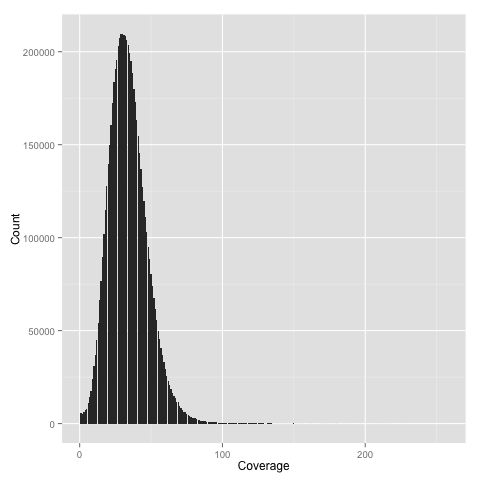

In [22]:
%%R
library(ggplot2)
cov=read.table("TAP1.coverage.txt", sep="\t")
cov[1,]
ggplot(cov, aes(x=V3, y=V4)) + geom_histogram(stat="identity") + xlab("Coverage") + ylab("Count")

In [23]:
%%bash
bwa mem -t 4 -R '@RG\tID:TAP2\tSM:TAP2' ST17.fasta TAP2_R1_paired.fastq.gz TAP2_R2_paired.fastq.gz |
  samtools view -bS - |
  samtools sort - TAP2.sorted
  
samtools index TAP2.sorted.bam

bwa mem -t 4 -R '@RG\tID:TAP3\tSM:TAP3' ST17.fasta TAP3_R1_paired.fastq.gz TAP3_R2_paired.fastq.gz |
  samtools view -bS - |
  samtools sort - TAP3.sorted
  
samtools index TAP3.sorted.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 263854 sequences (40000445 bp)...
[M::process] read 257252 sequences (40000316 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (207, 121137, 1, 127)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (85, 167, 284)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 682)
[M::mem_pestat] mean and std.dev: (191.50, 133.46)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 881)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (112, 171, 261)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 559)
[M::mem_pestat] mean and std.dev: (194.36, 108.40)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 708)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size dis

In [33]:
%%bash

bwa mem -t 4 -R '@RG\tID:PATIENT1\tSM:PATIENT1' ST17.fasta PATIENT1_R1.fastq.gz PATIENT1_R2.fastq.gz |
  samtools view -bS - |
  samtools sort - PATIENT1.sorted
  
samtools index PATIENT1.sorted.bam


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 211430 sequences (40000298 bp)...
[M::process] read 203188 sequences (40000170 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (585, 95684, 6, 291)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (242, 364, 503)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1025)
[M::mem_pestat] mean and std.dev: (375.93, 184.38)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1286)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (338, 448, 563)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1013)
[M::mem_pestat] mean and std.dev: (452.40, 173.08)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1238)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size

In [59]:
%%bash

bwa mem -t 4 -R '@RG\tID:PATIENT2\tSM:PATIENT2' ST17.fasta PATIENT2_R1.fastq.gz PATIENT2_R2.fastq.gz |
  samtools view -bS - |
  samtools sort - PATIENT2.sorted
  
samtools index PATIENT2.sorted.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 211376 sequences (40000188 bp)...
[M::process] read 198586 sequences (40000082 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (111, 97424, 3, 40)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (291, 420, 562)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1104)
[M::mem_pestat] mean and std.dev: (422.20, 182.02)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1375)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (415, 551, 690)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1240)
[M::mem_pestat] mean and std.dev: (552.22, 214.06)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1515)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size 

In [28]:
import os
os.environ['PATH'] = os.getenv('PATH') + ':../bin/freebayes/bin:../bin/vcflib/bin' 

Let's now call some SNPs. Use a ploidy value of 1 because these are bacteria and a coverage cut-off of >5.

In [36]:
!freebayes --ploidy 1 -C 5 -f ST17.fasta TAP1.sorted.bam PATIENT1.sorted.bam  > compare_tap1.vcf
!freebayes --ploidy 1 -C 5 -f ST17.fasta TAP2.sorted.bam PATIENT1.sorted.bam  > compare_tap2.vcf
!freebayes --ploidy 1 -C 5 -f ST17.fasta TAP3.sorted.bam PATIENT1.sorted.bam  > compare_tap3.vcf

In [38]:
!vcffilter -f "QUAL / AO > 10" compare_tap1.vcf | vcffilter -f "NS = 2" | wc -l 

    6675


Let's compare each pair

   * PATIENT1 vs TAP1
   * PATIENT1 vs TAP2
   * PATIENT1 vs TAP3
    
Let's also apply a hard quality filter "QUAL / AO > 10"

And let's exclude any positions that have "no calls" in either sample, by insisting on the number of samples with data being 2. "NS = 2"

Finally let's filter for SNPs that are discriminatory between samples:  "! ( SAME = germline ) "

In [47]:
!vcfsamplediff SAME TAP1 PATIENT1 compare_tap1.vcf | vcffilter -f "QUAL / AO > 10" | vcffilter -f "NS = 2" | vcffilter -f "! ( SAME = germline ) " | grep -v "^#" | wc -l 
!vcfsamplediff SAME TAP2 PATIENT1 compare_tap2.vcf | vcffilter -f "QUAL / AO > 10" | vcffilter -f "NS = 2" | vcffilter -f "! ( SAME = germline ) " | grep -v "^#" | wc -l 
!vcfsamplediff SAME TAP3 PATIENT1 compare_tap3.vcf | vcffilter -f "QUAL / AO > 10" | vcffilter -f "NS = 2" | vcffilter -f "! ( SAME = germline ) " | grep -v "^#" | wc -l 

       5
       5
   30680


Aha! Tap 1 and Tap 2 look to have the same number of differences compared to the patient, and tap 3 looks completely different! Why is that?

In [62]:
!vcfsamplediff SAME PATIENT1 TAP1 compare_tap1.vcf  | vcffilter -f "QUAL / AO > 10" | vcffilter -f "NS = 2" | vcffilter -f "! ( SAME = germline ) " > tap_differences.vcf 

In [64]:
!bedtools intersect -a ST17.gff -b tap_differences.vcf

chromosome	Prodigal:2.60	CDS	1439218	1439218	.	-	0	ID=NCTC13620_01334;gene=yfiR;inference=ab initio prediction:Prodigal:2.60,similar to AA sequence:RefSeq:YP_007708087.1,similar to AA sequence:UniProtKB:O31560,protein motif:CLUSTERS:PRK15008,protein motif:TIGRFAMs:TIGR03384,protein motif:Pfam:PF00440.17;locus_tag=NCTC13620_01334;product=putative transcriptional regulator,Uncharacterized HTH-type transcriptional regulator yfiR,HTH-type transcriptional regulator RutR,transcriptional repressor BetI,Bacterial regulatory proteins%2C tetR family;protein_id=gnl|SC|NCTC13620_01334
chromosome	Prodigal:2.60	CDS	2760378	2760380	.	-	0	ID=NCTC13620_02602;inference=ab initio prediction:Prodigal:2.60,similar to AA sequence:RefSeq:YP_261793.1,protein motif:TIGRFAMs:TIGR03756,protein motif:Pfam:PF06834.5;locus_tag=NCTC13620_02602;product=integrating conjugative element protein,integrating conjugative element protein%2C PFL_4710 family,TraU protein;protein_id=gnl|SC|NCTC13620_02602
chromosome	Prodigal:2

Do joint calling between the two patient isolates:

In [60]:
!freebayes --ploidy 1 -C 5 -f ST17.fasta PATIENT1.sorted.bam PATIENT2.sorted.bam > compare_patient.vcf

Call out the differences between the two patient isolates, filter for quality, remove no call positions and show only SNPs which are varying:

In [56]:
!vcfsamplediff SAME PATIENT1 TAP1 compare_patient.vcf  | vcffilter -f "QUAL / AO > 10" | vcffilter -f "NS = 2" | vcffilter -f "! ( SAME = germline ) " > patient_differences.vcf 

Let's look and see which genes might be affected by those mutations:

In [ ]:
!wget http://www.microbesng.uk/filedist/pseudomonas-practical/ST17.gff

In [58]:
!bedtools intersect -a ST17.gff -b patient_differences.vcf

chromosome	Prodigal:2.60	CDS	13886	13888	.	+	0	ID=NCTC13620_00011;eC_number=2.3.1.-;gene=htrB_1;inference=ab initio prediction:Prodigal:2.60,similar to AA sequence:RefSeq:YP_007706864.1,similar to AA sequence:UniProtKB:P0ACV0,protein motif:CLUSTERS:PRK05645,protein motif:Cdd:COG1560,protein motif:TIGRFAMs:TIGR02207,protein motif:Pfam:PF03279.7;locus_tag=NCTC13620_00011;product=lipid A biosynthesis lauroyl acyltransferase,Lipid A biosynthesis lauroyl acyltransferase,lipid A biosynthesis lauroyl acyltransferase,Lauroyl/myristoyl acyltransferase,lipid A biosynthesis lauroyl (or palmitoleoyl) acyltransferase,Bacterial lipid A biosynthesis acyltransferase;protein_id=gnl|SC|NCTC13620_00011
chromosome	Prodigal:2.60	CDS	2031140	2031140	.	+	0	ID=NCTC13620_01884;eC_number=5.99.1.3;gene=gyrA;inference=ab initio prediction:Prodigal:2.60,similar to AA sequence:RefSeq:YP_007708648.1,similar to AA sequence:UniProtKB:P0AES5,protein motif:CLUSTERS:PRK05560,protein motif:Cdd:COG0188,protein motif:TIGRFA

In [ ]:
Google "DNA gyrase antibiotic resistance"